### Autoencoders

#### References
- [Building autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [TF Intro to autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder)

<a href="https://colab.research.google.com/github/paulaceccon/dl-from-scratch/blob/main/name.ipynb" target="_parent" style="float: left;"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense

%load_ext tensorboard

![alt-text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

An **autoencoder** consists of input, hidden (bottleneck), and output layers.

1. Encoder:
Maps the input data to the network's internal representation.

2. Decoder:
Tries to reconstruct the input from the network's internal data representation.
  
  
The network is trained to find weights for the encoder and decoder that minimize the loss between the original input and the reconstruction of the input after it has passed through the encoder and decoder.
 
- Applications: 
    - Dimensionality Reduction
    - Feature Extraction
    - Image Denoising
    - Image Compression
    - Image Search
    - Anomaly Detection
    - Missing Value Imputation

### Load the dataset

In [2]:
def preprocess(data: np.array) -> np.ndarray:
    data = data.astype("float32") / 255.0
    data = data.reshape((len(data), np.prod(data.shape[1:])))
    return data

In [3]:
(x_train, y_train), (x_test, _) = mnist.load_data()
x_train = preprocess(x_train)
x_test = preprocess(x_test)

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Visualization

In [4]:
def plot_figures(original: np.ndarray, decoded: np.ndarray) -> None:
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [5]:
def plot_latent_distribution(
    autoencoder: Model, data: np.ndarray, labels: np.ndarray
) -> None:
    encoded = autoencoder.encoder.predict(data)
    plt.figure(figsize=(6, 6))
    plt.scatter(encoded[:, 0], encoded[:, 1], c=labels)
    plt.colorbar()

In [6]:
def plot_latent_space(autoencoder: Model, n_samples: int = 15):
    # Display a 2D manifold of the digits
    digit_size = 28
    figure = np.zeros((digit_size * n_samples, digit_size * n_samples))
    grid_x = np.linspace(-15, 15, n_samples)
    grid_y = np.linspace(-15, 15, n_samples)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = autoencoder.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure)

### Model

In [7]:
class Encoder(Model):
    def __init__(self):
        super().__init__(name="encoder")
        self.encoder = Sequential(
            [
                Input(shape=(784,)),
                Dense(256, activation="relu"),
                Dense(128, activation="relu"),
                Dense(64, activation="relu"),
                Dense(32, activation="relu"),
                Dense(2, activation="relu"),
            ]
        )

    def call(self, inputs):
        return self.encoder(inputs)

In [8]:
class Decoder(Model):
    def __init__(self):
        super().__init__(name="decoder")
        self.decoder = Sequential(
            [
                Dense(32, activation="relu"),
                Dense(64, activation="relu"),
                Dense(128, activation="relu"),
                Dense(256, activation="relu"),
                Dense(784, activation="sigmoid"),
            ]
        )

    def call(self, inputs):
        return self.decoder(inputs)

In [9]:
class Autoencoder(Model):
    """Implements a basic autoencoder."""

    def __init__(self, name: str = "autoencoder"):
        super().__init__(name=name)
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

### Training

In [10]:
def train_model(train_data: np.ndarray, test_data: np.ndarray) -> Autoencoder:
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

    autoencoder = Autoencoder()
    autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
    autoencoder.fit(
        train_data,
        train_data,
        epochs=100,
        batch_size=128,
        shuffle=True,
        validation_data=(test_data, test_data),
        verbose=0,
        callbacks=[EarlyStopping(patience=5), tensorboard_callback],
    )
    return autoencoder

In [11]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 7472), started 0:09:49 ago. (Use '!kill 7472' to kill it.)

In [12]:
autoencoder = train_model(x_train, x_test)

2022-03-02 16:14:18.031514: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  244258    
                                                                 
 decoder (Decoder)           multiple                  245040    
                                                                 
Total params: 489,298
Trainable params: 489,298
Non-trainable params: 0
_________________________________________________________________


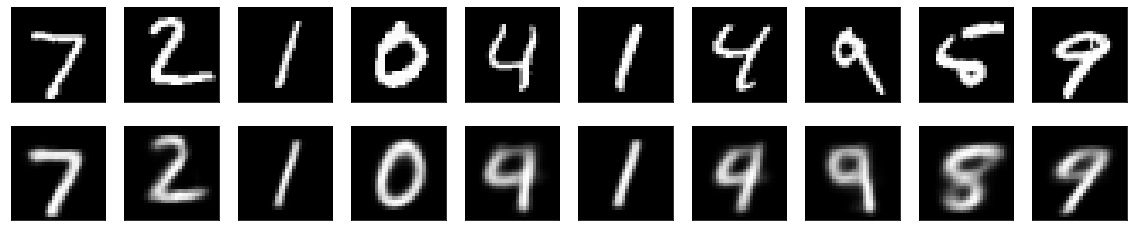

In [14]:
decoded_imgs = autoencoder.predict(x_test)
plot_figures(x_test, decoded_imgs)

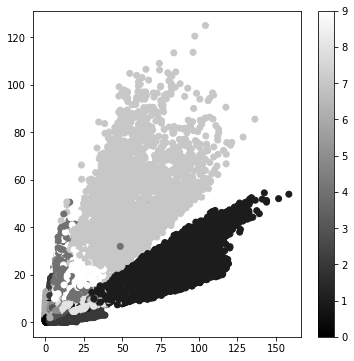

In [15]:
plot_latent_distribution(autoencoder, x_train, y_train)

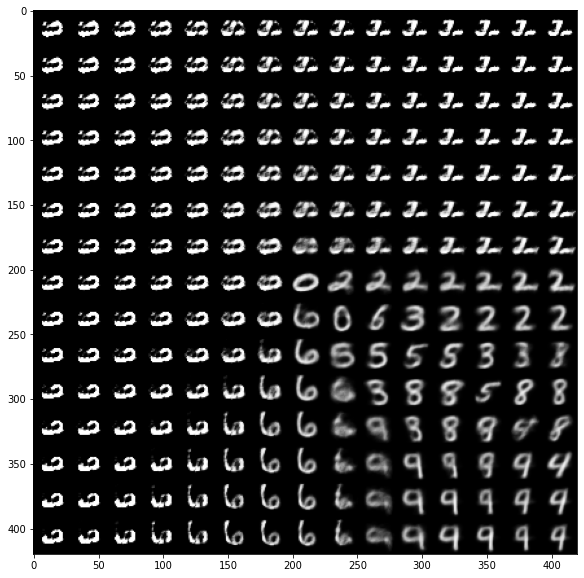

In [16]:
plot_latent_space(autoencoder, n_samples=15)

Some points may not be decoded into well-formed images. This is because the autoencoder is not forced to ensure 
that the space is continuous.